In [38]:
# load packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests

# Load Data

In [2]:
df = pd.read_csv('Task 1 DNA_sequences.csv')
sequences = df['Sequences']
labels = df['labels']

In [3]:
# use one-hot encoding to get each DNA sequence in the form of a matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# The LabelEncoder encodes a sequence of bases as a sequence of integers.
integer_encoder = LabelEncoder()
# The OneHotEncoder converts an array of integers to a sparse matrix where
# each row corresponds to one possible value of each feature.
one_hot_encoder = OneHotEncoder(categories='auto')
input_features = []

for sequence in sequences:
  integer_encoded = integer_encoder.fit_transform(list(sequence))
  integer_encoded = np.array(integer_encoded).reshape(-1, 1)
  one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
  input_features.append(one_hot_encoded.toarray())

np.set_printoptions(threshold=40)
input_features = np.stack(input_features)
print("Example sequence\n-----------------------")
print('DNA Sequence #1:\n',sequences[0][:10],'...',sequences[0][-10:])
print('One hot encoding of Sequence #1:\n',input_features[0].T)

Example sequence
-----------------------
DNA Sequence #1:
 CCGAGGGCTA ... CGCGGACACC
One hot encoding of Sequence #1:
 [[0. 0. 0. ... 1. 0. 0.]
 [1. 1. 0. ... 0. 1. 1.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [4]:
# use one-hot encoding to encode the labels
one_hot_encoder = OneHotEncoder(categories='auto')
labels = np.array(labels).reshape(-1, 1)
input_labels = one_hot_encoder.fit_transform(labels).toarray()

print('Labels:\n',labels.T)
print('One-hot encoded labels:\n',input_labels.T)

Labels:
 [[0 0 0 ... 0 1 1]]
One-hot encoded labels:
 [[1. 1. 1. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 1.]]


In [5]:
# split the data into training and test sets
# partition the training set into a training and validation set.
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(
    input_features, input_labels, test_size=0.25, random_state=42)

# Model Building and Evaluation

Since we are working with one-hot encoded DNA sequences, a simple feedforward neural network can be a good starting point. 
For more complex patterns, convolutional neural networks (CNNs) are often used in sequence analysis because they can detect motifs within the sequences that are indicative of binding sites.

In [6]:
# Build a model
# Keras of Tensorflow is used

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Dropout
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns


from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Dropout

def DNN_classifier(input_shape):
    # Define the model
    model = Sequential()

    # Add a convolutional layer to identify motifs
    # Conv1D layers are used to find patterns across the sequence dimension of the input,
    # which is particularly useful for tasks like motif recognition in DNA sequences.
    model.add(Conv1D(filters=32, kernel_size=12, activation='relu', input_shape=input_shape))
    
    
    # MaxPooling1D is used to reduce the dimensionality of the input, helping to make the detection
    # of motifs invariant to their position in the sequence and also to reduce the computation required.
    model.add(MaxPooling1D(pool_size=4))
    
    # Dropout is a regularization technique where input units are randomly dropped, along with their connections,
    # which helps prevent overfitting by ensuring that the model does not rely too heavily on any one node.
    model.add(Dropout(0.5))
    
    # Flatten the output of the convolutional layers to make it compatible with the dense layers that follow.
    # This is because dense layers expect a flat vector of features for each input sample.
    model.add(Flatten())
    
    
    # Add one or more dense layers for classification. Dense layers are the core building blocks of neural networks,
    # providing a high degree of interconnection between nodes, which allows the network to learn complex patterns.
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    
    # Another dropout layer to further prevent overfitting, especially given the increased number of
    # parameters from the dense layers which could otherwise lead to memorization of the training data.
    model.add(Dropout(0.5))
    
    # Output layer for binary classification with 2 units (for two classes) and softmax activation.
    # Softmax is used because it outputs a probability distribution over the classes, making it suitable for classification.
    model.add(Dense(2, activation='softmax'))
    
    #Compile the model with the Adam optimizer, which is a stochastic gradient descent method that is based on
    # adaptive estimation of first- and second-order moments. Binary crossentropy is used as the loss function
    # for binary classification, and accuracy is specified as the metric for evaluation.
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model


16/16 [==============================] - 0s 2ms/step


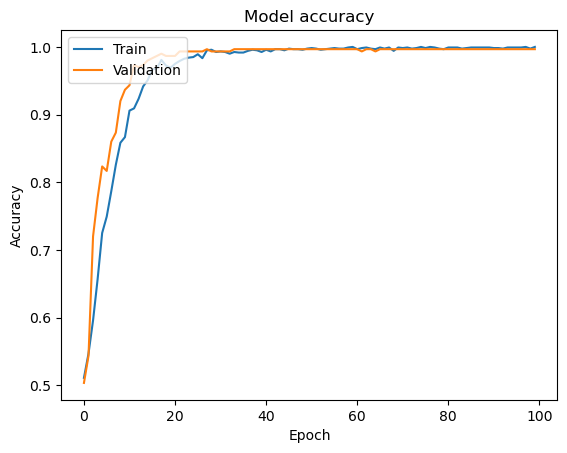

Accuracy: 99.80%
Confusion Matrix:
[[258   1]
 [  0 241]]


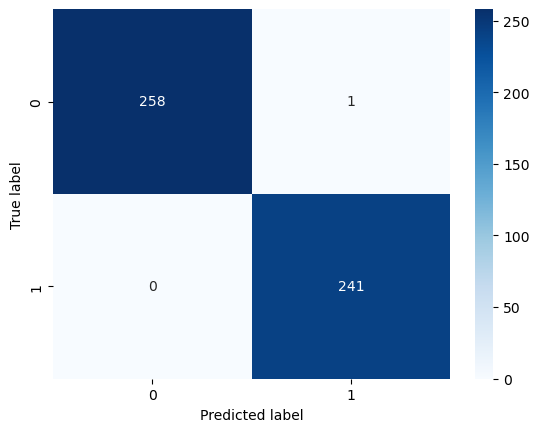

In [7]:
# evaluate the performance of the model and plot accuracy figures and the confusion matrix

from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

def evaluate_model(model, test_features, test_labels):
    # Predict classes using the testing data
    predictions = model.predict(test_features)
    predictions = np.argmax(predictions, axis=1)
    test_labels = np.argmax(test_labels, axis=1)

    # Calculate the accuracy of the model
    accuracy = accuracy_score(test_labels, predictions)

    # Generate a confusion matrix
    cm = confusion_matrix(test_labels, predictions)

    return accuracy, cm

# Use the model to get predictions
model = DNN_classifier(input_shape=(train_features.shape[1], train_features.shape[2]))
history = model.fit(train_features, train_labels, epochs=100, batch_size=128, verbose=0, validation_split=0.2)

# Evaluate the model
accuracy, cm = evaluate_model(model, test_features, test_labels)

# Plot accuracy
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Print the accuracy
print(f"Accuracy: {accuracy*100:.2f}%")

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


## Report on Model Accuracy

#### **Accuracy:** 
The accuracy 99.80%. This means that 99.80% of the predictions made by the model are correct. In other words, almost all of the sequences were correctly classified as either binding or not binding to the protein.

#### **Confusion Matrix:** 
The confusion matrix is a 2x2 grid that shows the number of true positives, false positives, true negatives, and false negatives.

- Top-Left (True Negative, TN): 258 sequences were correctly predicted as not binding to the protein (label 0). <br>
- Top-Right (False Positive, FP): 1 sequence was incorrectly predicted as binding to the protein (label 1) when it does not. <br>
- Bottom-Left (False Negative, FN): 0 sequences were incorrectly predicted as not binding to the protein (label 0) when they do. <br>
- Bottom-Right (True Positive, TP): 241 sequences were correctly predicted as binding to the protein (label 1). <br>

Here is what this tells us: <br><br>
The model has a high true positive rate (TPR), meaning it is very good at identifying sequences that bind to the protein.
The false positive rate (FPR) is very low, with only 1 case where the model predicted binding, but it was incorrect.
The true negative rate (TNR) is also high, indicating the model is good at identifying sequences that do not bind to the protein.
There are no false negatives (FN), meaning every sequence that actually binds to the protein was identified correctly by the model.
**In summary, the model is highly accurate with a negligible rate of misclassification.** However, such a high level of performance on a test dataset can sometimes be indicative of overfitting, especially if the test set is not large enough or not representative of real-world data. It would be sensible to validate the model further with cross-validation and possibly with an independent dataset to ensure that the model is truly **_generalizable_**.

## Comment on Accuracy vs Epochs plot
From the plot it can be observed that test/validation set shows higher accuracy than the train set in the begining and then they merge after around epoch 30. This unusual trend can be due to several factors; <br>

- **Small Validation Set:**  If the validation set is small, it might not be representative. A few easy-to-classify examples could skew the accuracy higher.
- **Regularization:** If there are regularization techniques (like dropout used here) applied, they are typically active during training but not during validation/testing. This can sometimes make the training accuracy appear lower, as the model is being penalized for complexity during training.
- **Random Chance:** If the initial model parameters just happen to perform better on the validation set by chance. This is more likely if the dataset is small.

#### Other Observations: 
- **Convergence After 30 Epochs:** When both accuracies merge, it generally means the model has started to generalize better, learning patterns that are equally valid for both the training and validation datasets.

- **Stable Performance Post Convergence:**  After epoch 30, the training and validation accuracies seem to converge and follow the same trend, which is desirable. This indicates that the model is not overfitting significantly to the training data. Overfitting would be indicated by a training accuracy that continues to increase while the validation accuracy decreases or plateaus.

Here’s what we generally want in a training/validation accuracy plot:
- **Training and Validation Accuracies Converging:** Ideally, we want the two lines to be as close as possible, indicating that the model is generalizing well and not overfitting.
- **High Final Accuracy:** The closer these lines are to the top of the graph (high accuracy), the better the model is performing.
- **No Large Gaps:** A large gap between the training and validation lines suggests overfitting. If the training line is much higher, the model may be learning patterns specific to the training data that do not generalize to new data.

# Visualization and Interpretation

In [8]:
# incomplete
# compute a saliency map [the gradient of the model's prediction with respect to each individual nucleotide]
# def saliency_base(model, data):
#   sal = TODO
#   return sal

import tensorflow as tf


# compute a saliency map [the gradient of the model's prediction with respect to each individual nucleotide]
def saliency_base(model, data):
    """
    Compute the saliency map for the given data and model.
    
    :param model: The trained Keras model.
    :param data: The input data for which to compute the saliency map.
    :return: The computed saliency map.
    """
    # Convert the data to a TensorFlow tensor.
    data_tensor = tf.convert_to_tensor(data, dtype=tf.float32)
    
    # Initialize GradientTape to record the gradients.
    with tf.GradientTape() as tape:
        # Watch the input data for the gradient computation.
        tape.watch(data_tensor)
        
        # Use the model to predict the output.
        predictions = model(data_tensor)
        
        # Since we have a single output node, we take the gradient with respect to that node.
        output_to_use = predictions[:, 0]
    
    # Compute the gradients of the predictions with respect to the input data.
    gradients = tape.gradient(output_to_use, data_tensor)
    
    # Convert the gradients to their absolute values.
    sal = tf.abs(gradients)
    
    return sal




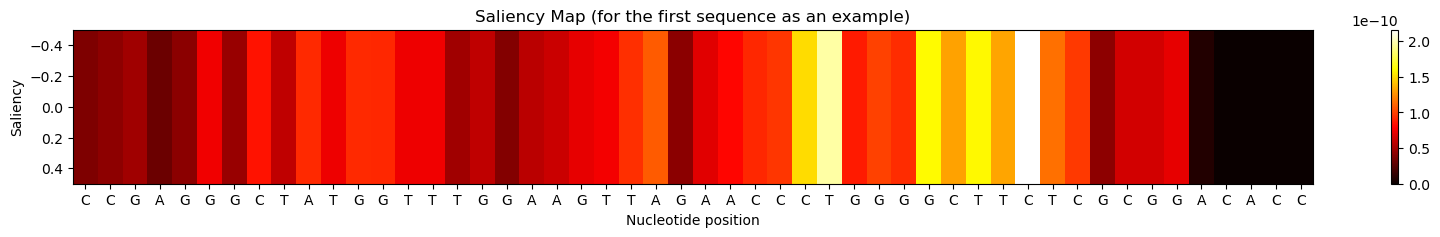

In [13]:
# Compute the saliency maps for all sequences
saliency_maps = saliency_base(model, input_features)

# Function to plot the saliency map for a given DNA sequence
def plot_saliency_map(saliency, sequence, title="Saliency Map (for the first sequence as an example)"):
    """
    Plot the saliency map for a given DNA sequence.
    
    :param saliency: The saliency map data.
    :param sequence: The DNA sequence (string).
    :param title: The title for the plot.
    """
    # Collapse the saliency map to get the maximum value at each position.
    saliency_collapsed = np.max(saliency, axis=-1)

    # Make sure saliency_collapsed is 2D
    if saliency_collapsed.ndim == 1:
        saliency_collapsed = np.expand_dims(saliency_collapsed, axis=0)

    # Create a figure to visualize the saliency map.
    plt.figure(figsize=(20, 2))
    plt.imshow(saliency_collapsed, cmap='hot', aspect='auto')
    plt.colorbar()
    plt.title(title)
    plt.ylabel('Saliency')
    plt.xlabel('Nucleotide position')
    plt.xticks(range(len(sequence)), list(sequence))
    plt.show()

# Visualize the saliency map for the first sequence as an example
plot_saliency_map(saliency_maps[0].numpy(), sequences.iloc[0])


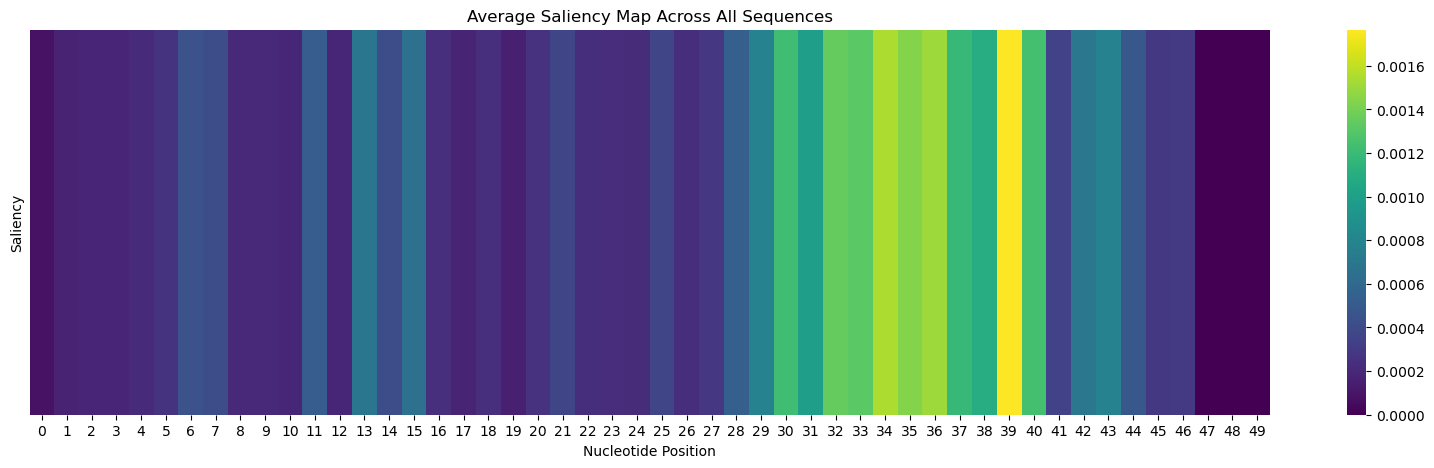

In [14]:
# Saliency_maps is a 3D array with shape (number_of_sequences, sequence_length, 4) - to check run: np.shape(saliency_maps)
# where 4 represents the one-hot encoded nucleotides (A, C, G, T)
saliency_collapsed = np.max(saliency_maps, axis=-1)  # Max over the one-hot encoded dimension
average_saliency = np.mean(saliency_collapsed, axis=0)  # Mean over all sequences

# Ensure average_saliency is 2D for visualizing as a heatmap
average_saliency = np.expand_dims(average_saliency, axis=0)

plt.figure(figsize=(20, 5))
sns.heatmap(average_saliency, annot=False, cmap='viridis', cbar=True, yticklabels=False)
plt.title('Average Saliency Map Across All Sequences')
plt.ylabel('Saliency')
plt.xlabel('Nucleotide Position')
plt.show()


In [36]:
average_saliency_per_position = np.mean(saliency_collapsed, axis=0)
ranked_positions = np.argsort(average_saliency_per_position)[::-1]

# Let's display the top contributing positions and their corresponding saliency values.
top_contributing_positions = ranked_positions[:10]  # Let's take top 10 for example
top_saliency_values = average_saliency_per_position[top_contributing_positions]

top_contributing_positions, top_saliency_values

(array([39, 34, 36, 35, 32, 33, 40, 30, 37, 38], dtype=int64),
 array([0.0017655 , 0.00154958, 0.00150843, 0.00143671, 0.00134793,
        0.00131202, 0.00123728, 0.00122151, 0.00118442, 0.00110164],
       dtype=float32))

10 most contributing positions are ranked as below; <br>
- 1.Position 39 with an average saliency of 0.0017655 <br>
- 2.Position 34 with an average saliency of 0.00154958 <br>
- 3.Position 36 with an average saliency of 0.00150843 <br>
- 4.Position 35 with an average saliency of 0.00143671 <br>
- 5.Position 32 with an average saliency of 0.00134793 <br>
- 6.Position 33 with an average saliency of 0.00131202 <br>
- 7.Position 40 with an average saliency of 0.00123728 <br>
- 8.Position 30 with an average saliency of 0.00122151 <br>
- 9.Position 37 with an average saliency of 0.00118442 <br>
- 10.Position 38 with an average saliency of 0.00110164 <br>

**These positions are the ones where changes to the nucleotide sequence would most impact the predictions of the model, indicating their importance in the model's decision-making process.**

In [ ]:
# feel free to use other visualization methods here
# some examples here https://hidivelab.org/research/projects/gosling/